In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker


In c:\Users\Jason\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\Users\Jason\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\Users\Jason\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\Users\Jason\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\Users\Jason\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

This File combines Stock Market Data, FED & NLP data for use in XGBoost and later models

Reading in DF and Merging files

In [42]:
df = pd.read_csv('test_60_40_advanced.csv')
fed_data = pd.read_csv('Full_Fed_Minutes_test.csv')
NER_data = pd.read_csv('NLP_FOMC_people_07_19.csv')
NER_data = NER_data.rename(columns={'Unnamed: 0':'Date'})

fed_df = pd.DataFrame(fed_data)
fed_df = fed_df.rename(columns={'index':'Date'})
fed_df=fed_df.drop(['Unnamed: 0'], axis=1)
df = pd.DataFrame(df)
df = pd.merge(df,fed_df, how='left', on = 'Date', suffixes = ('_left', '_right'))
df =df.drop(columns={'Score'})
df.head(36)


window = 2

In [43]:
# tickers to aggregate price only
ticker_test = ['XLE','XLU','XLK','XLB','XLP','XLY','XLI','XLC','XLV','XLF','XLRE','TLT','HYBL','SJNK','SPTI']

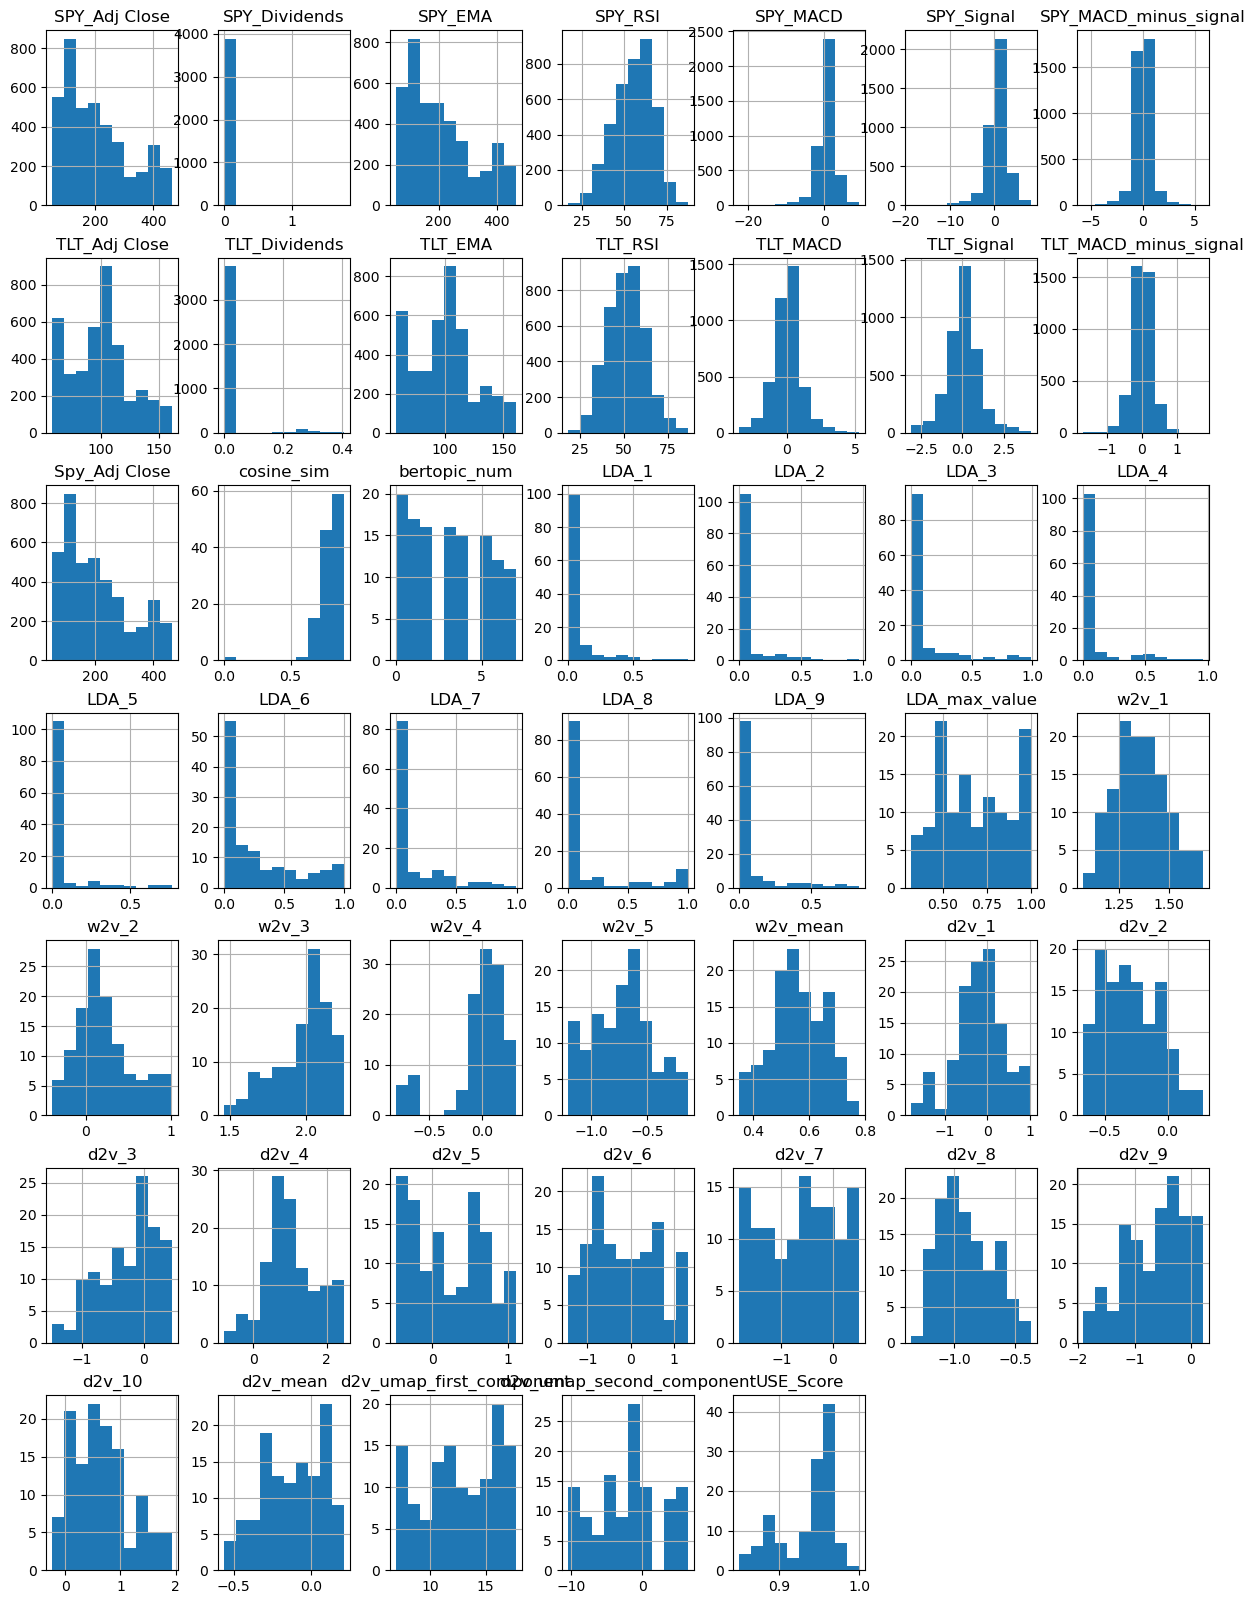

In [136]:
# Plotting DF to understand returns and how to Scale
# potentailly opting not to transform because random forest classifier doesnt need it
df.hist(figsize=(15,20))

plt.show()

Building Functions

In [44]:
# This function creates a window around a specific date to calculate averages. A window of 2 gives 2 days before and 2 days after a date
def window_func(df,i,window):
    window_1 = window+1
    
    if df['Date'].str.contains(str(i)).sum() >0:
        idx = df[df['Date']==str(i)].index
        
        df_out = df.iloc[idx[0]-window : idx[0]+window_1]
        
        
        return df_out

In [45]:
window = 2

release_window_df = []
for i in fed_df['Date']:

    out = window_func(df,i,window)
    out = pd.DataFrame(out).mean(numeric_only=True) # not sure why it wants me to force the df call again
    
    release_window_df.append(out)

result = release_window_df#pd.concat(release_window_df)
avg_df = pd.DataFrame(result)
num_df = avg_df.loc[:, avg_df.columns!='Score'] # removing sentiment score from percentage change calculation. (For Now)
#num_df = num_df.interpolate() # one missing row of data

#log_df = np.log(num_df)

# testing pct-change
log_df = num_df.pct_change()

#log_df = np.log(num_df) - np.log(num_df).shift(1)
Final_df = log_df.assign(Date=fed_df['Date'],Sent_TFMR=fed_df['Score']) # append non percentage change columns back



first_column = Final_df.pop('Date') # moving date to the left column, popping it off first
  

Final_df.insert(0, 'Date', first_column) # re inserting it



# Dropping dividend columns for now, will be treated as an add back to total return

#Final_df = Final_df.drop(columns=['SPY_Dividends','TLT_Dividends'])
#df.drop(columns=['B', 'C'])
Final_df

,Date,SPY_Adj Close,SPY_EMA,SPY_RSI,SPY_MACD,SPY_Signal,SPY_MACD_minus_signal,XLE_Adj Close,XLU_Adj Close,XLK_Adj Close,...,FIMA,Thomas,Thomas Laubach,Chair Powell,COVID-19,Christopher J. Waller,Lisa D. Cook,Austan D. Goolsbee,Lorie K. Logan,Sent_TFMR
0,2008-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.368000
1,2008-03-18,-0.040333,-0.032914,-0.006085,-0.424618,-0.490192,-1.962684,0.033571,-0.027711,-0.041025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333
2,2008-04-30,0.072622,0.068892,0.418370,-1.923876,-1.815797,-3.266342,0.121542,0.064906,0.094163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.446352
3,2008-08-05,-0.087152,-0.084510,-0.206954,-1.491858,-2.065707,1.073898,-0.109106,-0.076246,-0.069874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714
4,2008-09-16,-0.047982,-0.032131,-0.188235,1.085476,-0.315740,-2.133915,-0.086172,-0.059798,-0.075975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.323529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-12-14,0.044281,0.041598,-0.014924,0.800649,-7.004802,-1.644977,-0.053801,0.077550,0.069866,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.504762
119,2023-02-01,0.040276,0.029073,0.255113,0.985196,-0.079558,-2.120765,0.039472,-0.035884,0.054443,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,inf,inf,0.500000
120,2023-03-22,-0.032138,-0.027845,-0.224276,-1.402420,-1.647285,-0.815802,-0.096021,-0.043140,0.044649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.333333,-1.0,0.552941
121,2023-05-03,0.039748,0.045171,0.069533,-2.136432,-2.260043,-3.177060,0.022791,0.049423,0.033364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.478632


In [11]:
def Fed_Date_Avg(fed_df,df, window):
    release_window_df = []
    for i in fed_df['Date']:

        out = window_func(df,i,window)
        out = pd.DataFrame(out).mean(numeric_only=True) # not sure why it wants me to force the df call again
        
        release_window_df.append(out)

    result = release_window_df#pd.concat(release_window_df)
    avg_df = pd.DataFrame(result)
    num_df = avg_df.loc[:, avg_df.columns!='Score'] # removing sentiment score from percentage change calculation. (For Now)
    #num_df = num_df.interpolate() # one missing row of data

    #log_df = np.log(num_df)

    # testing pct-change
    log_df = num_df.pct_change()

    #log_df = np.log(num_df) - np.log(num_df).shift(1)
    Final_df = log_df.assign(Date=fed_df['Date'],Sent_TFMR=fed_df['Score']) # append non percentage change columns back



    first_column = Final_df.pop('Date') # moving date to the left column, popping it off first
    

    Final_df.insert(0, 'Date', first_column) # re inserting it

    # Dropping dividend columns for now, will be treated as an add back to total return
    #Final_df = Final_df.drop(columns=['SPY_Dividends','TLT_Dividends'])
    #df.drop(columns=['B', 'C'])
 

    return Final_df

In [38]:
Final_df = Fed_Date_Avg(fed_df,df,window) # change to Final_df


In [46]:
Final_df.head()

,Date,SPY_Adj Close,SPY_EMA,SPY_RSI,SPY_MACD,SPY_Signal,SPY_MACD_minus_signal,XLE_Adj Close,XLU_Adj Close,XLK_Adj Close,...,FIMA,Thomas,Thomas Laubach,Chair Powell,COVID-19,Christopher J. Waller,Lisa D. Cook,Austan D. Goolsbee,Lorie K. Logan,Sent_TFMR
0,2008-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.368000
1,2008-03-18,-0.040333,-0.032914,-0.006085,-0.424618,-0.490192,-1.962684,0.033571,-0.027711,-0.041025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333
2,2008-04-30,0.072622,0.068892,0.418370,-1.923876,-1.815797,-3.266342,0.121542,0.064906,0.094163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.446352
3,2008-08-05,-0.087152,-0.084510,-0.206954,-1.491858,-2.065707,1.073898,-0.109106,-0.076246,-0.069874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714
4,2008-09-16,-0.047982,-0.032131,-0.188235,1.085476,-0.315740,-2.133915,-0.086172,-0.059798,-0.075975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.323529


In [27]:
## what I am trying to do is make a y variable of the future returns of the next 8 weeks based off of reactions around fed mins.

#Full_df= Final_df[Final_df['Date'].isin(fed_df['Date'])]

##Full_df.loc[:,Full_df.columns!='Date'].diff() # i need a logic check on this
#Full_df['Return_Next_FOMC'] = Full_df['SPY_Adj Close'].shift(-1)-Full_df['SPY_Adj Close'] # take close since last fed meeting and subtract from previous to get change for the period

#for i in ticker_test:
#    Full_df['Return_Next_FOMC '+(i)] = Full_df[(i)+'_Adj Close'].shift(-1)-Full_df[(i)+'_Adj Close']    

#Full_df


In [47]:
def add_NER(df,NER_data):
    combined_df = pd.merge(df,NER_data, how='left', on = 'Date', suffixes = ('_left', '_right'))
    return combined_df

In [48]:
Final_df = add_NER(Final_df,NER_data)
Final_df

,Date,SPY_Adj Close,SPY_EMA,SPY_RSI,SPY_MACD,SPY_Signal,SPY_MACD_minus_signal,XLE_Adj Close,XLU_Adj Close,XLK_Adj Close,...,YCT_right,FIMA_right,Thomas_right,Thomas Laubach_right,Chair Powell_right,COVID-19_right,Christopher J. Waller_right,Lisa D. Cook_right,Austan D. Goolsbee_right,Lorie K. Logan_right
0,2008-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2008-03-18,-0.040333,-0.032914,-0.006085,-0.424618,-0.490192,-1.962684,0.033571,-0.027711,-0.041025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2008-04-30,0.072622,0.068892,0.418370,-1.923876,-1.815797,-3.266342,0.121542,0.064906,0.094163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2008-08-05,-0.087152,-0.084510,-0.206954,-1.491858,-2.065707,1.073898,-0.109106,-0.076246,-0.069874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2008-09-16,-0.047982,-0.032131,-0.188235,1.085476,-0.315740,-2.133915,-0.086172,-0.059798,-0.075975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-12-14,0.044281,0.041598,-0.014924,0.800649,-7.004802,-1.644977,-0.053801,0.077550,0.069866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
119,2023-02-01,0.040276,0.029073,0.255113,0.985196,-0.079558,-2.120765,0.039472,-0.035884,0.054443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
120,2023-03-22,-0.032138,-0.027845,-0.224276,-1.402420,-1.647285,-0.815802,-0.096021,-0.043140,0.044649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
121,2023-05-03,0.039748,0.045171,0.069533,-2.136432,-2.260043,-3.177060,0.022791,0.049423,0.033364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [49]:
def Forward_Return(Final_df,fed_df):
    # what I am trying to do is make a y variable of the future returns of the next 8 weeks based off of reactions around fed mins.

    Full_df= Final_df[Final_df['Date'].isin(fed_df['Date'])]

    ##Full_df.loc[:,Full_df.columns!='Date'].diff() # i need a logic check on this
    Full_df['Return_Next_FOMC'] = Full_df['SPY_Adj Close'].shift(-1)-Full_df['SPY_Adj Close'] # take close since last fed meeting and subtract from previous to get change for the period
    #Full_df['Return_Next_FOMC'] = Full_df['SPY_Adj Close'].diff() # i need a logic check on this
    for i in ticker_test:
        Full_df['Return_Next_FOMC '+(i)] = Full_df[(i)+'_Adj Close'].shift(-1)-Full_df[(i)+'_Adj Close']    


    return Full_df

In [52]:
Full_df = Forward_Return(Final_df,fed_df)
#experimenting ##################
#a=Full_df['Return_Next_FOMC'].shift(-1)
#Full_df['Return_Next_FOMC']=a
Full_df.head(10)

######

,Date,SPY_Adj Close,SPY_EMA,SPY_RSI,SPY_MACD,SPY_Signal,SPY_MACD_minus_signal,XLE_Adj Close,XLU_Adj Close,XLK_Adj Close,...,Return_Next_FOMC XLY,Return_Next_FOMC XLI,Return_Next_FOMC XLC,Return_Next_FOMC XLV,Return_Next_FOMC XLF,Return_Next_FOMC XLRE,Return_Next_FOMC TLT,Return_Next_FOMC HYBL,Return_Next_FOMC SJNK,Return_Next_FOMC SPTI
0,2008-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-03-18,-0.040333,-0.032914,-0.006085,-0.424618,-0.490192,-1.962684,0.033571,-0.027711,-0.041025,...,0.116776,0.065830,NaN,0.100322,0.231479,NaN,-0.047548,NaN,NaN,-0.044826
2,2008-04-30,0.072622,0.068892,0.418370,-1.923876,-1.815797,-3.266342,0.121542,0.064906,0.094163,...,-0.176824,-0.154004,NaN,-0.002307,-0.285928,NaN,0.030104,NaN,NaN,0.026576
3,2008-08-05,-0.087152,-0.084510,-0.206954,-1.491858,-2.065707,1.073898,-0.109106,-0.076246,-0.069874,...,0.145496,0.039288,NaN,-0.056560,0.097725,NaN,0.071796,NaN,NaN,0.019674
4,2008-09-16,-0.047982,-0.032131,-0.188235,1.085476,-0.315740,-2.133915,-0.086172,-0.059798,-0.075975,...,-0.329756,-0.220661,NaN,-0.141771,-0.167167,NaN,-0.093394,NaN,NaN,-0.023896
5,2008-10-29,-0.228701,-0.249679,0.059314,3.336092,7.029263,-1.784362,-0.278640,-0.173534,-0.219244,...,0.297278,0.244033,NaN,0.159495,0.104707,NaN,0.264455,NaN,NaN,0.053969
6,2008-12-16,-0.032376,-0.024442,0.196719,-0.918915,-0.792816,0.870789,0.014380,0.013151,-0.045869,...,-0.075824,-0.029382,NaN,0.048763,-0.077109,NaN,-0.330855,NaN,NaN,-0.064212
7,2009-01-28,-0.050092,-0.048592,-0.097803,1.576611,-0.219561,-1.246630,-0.001021,0.036042,-0.017386,...,0.010881,-0.089437,NaN,-0.127511,0.143707,NaN,0.064522,NaN,NaN,0.010757
8,2009-03-18,-0.075819,-0.092293,0.169930,-0.047862,1.191152,-6.210533,-0.090772,-0.143459,-0.001174,...,0.287707,0.365440,NaN,0.103485,0.341799,NaN,-0.010947,NaN,NaN,-0.003752
9,2009-04-29,0.118460,0.135033,0.105096,-2.395974,-1.748957,-1.042658,0.060900,0.036159,0.143659,...,-0.236769,-0.201967,NaN,0.067122,-0.161478,NaN,-0.012522,NaN,NaN,-0.015944


In [65]:
#def Bull_bear(df):
    
#    for i in range(len(df)):
#        
#        if df['Return_Next_FOMC'][i]>0:
#       #     print(i)
#            df['Bull_Bear'][i] = 1 
#        
#        else:
#            df['Bull_Bear'][i] = 0
#    return df

In [53]:
def Bull_bear(df):
    df['Bull_Bear'] = 0
    #df.loc[df['Return_Next_FOMC'] > 0, 'Bull_Bear'] = 1
    df.loc[df['Return_Next_FOMC'] > 0, 'Bull_Bear'] = 1
    return df

In [54]:
df_trade = Bull_bear(Full_df)
#df_trade.to_csv('NLP_df.csv')
df_trade.to_csv('FED_window_df.csv')
df_trade

,Date,SPY_Adj Close,SPY_EMA,SPY_RSI,SPY_MACD,SPY_Signal,SPY_MACD_minus_signal,XLE_Adj Close,XLU_Adj Close,XLK_Adj Close,...,Return_Next_FOMC XLI,Return_Next_FOMC XLC,Return_Next_FOMC XLV,Return_Next_FOMC XLF,Return_Next_FOMC XLRE,Return_Next_FOMC TLT,Return_Next_FOMC HYBL,Return_Next_FOMC SJNK,Return_Next_FOMC SPTI,Bull_Bear
0,2008-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2008-03-18,-0.040333,-0.032914,-0.006085,-0.424618,-0.490192,-1.962684,0.033571,-0.027711,-0.041025,...,0.065830,NaN,0.100322,0.231479,NaN,-0.047548,NaN,NaN,-0.044826,1
2,2008-04-30,0.072622,0.068892,0.418370,-1.923876,-1.815797,-3.266342,0.121542,0.064906,0.094163,...,-0.154004,NaN,-0.002307,-0.285928,NaN,0.030104,NaN,NaN,0.026576,0
3,2008-08-05,-0.087152,-0.084510,-0.206954,-1.491858,-2.065707,1.073898,-0.109106,-0.076246,-0.069874,...,0.039288,NaN,-0.056560,0.097725,NaN,0.071796,NaN,NaN,0.019674,1
4,2008-09-16,-0.047982,-0.032131,-0.188235,1.085476,-0.315740,-2.133915,-0.086172,-0.059798,-0.075975,...,-0.220661,NaN,-0.141771,-0.167167,NaN,-0.093394,NaN,NaN,-0.023896,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-12-14,0.044281,0.041598,-0.014924,0.800649,-7.004802,-1.644977,-0.053801,0.077550,0.069866,...,-0.035541,0.094729,-0.090111,0.044513,-0.000219,-0.126082,-0.000478,-0.006093,-0.027166,0
119,2023-02-01,0.040276,0.029073,0.255113,0.985196,-0.079558,-2.120765,0.039472,-0.035884,0.054443,...,-0.070623,-0.155665,-0.006761,-0.202964,-0.191048,-0.009147,-0.042077,-0.045769,-0.003948,0
120,2023-03-22,-0.032138,-0.027845,-0.224276,-1.402420,-1.647285,-0.815802,-0.096021,-0.043140,0.044649,...,0.063278,0.051787,0.095625,0.168233,0.164055,0.004005,0.044693,0.044709,0.004113,1
121,2023-05-03,0.039748,0.045171,0.069533,-2.136432,-2.260043,-3.177060,0.022791,0.049423,0.033364,...,0.031927,0.054250,-0.068149,0.004836,-0.027616,-0.020466,-0.021480,-0.011539,-0.030738,1


Average Returns by Sector/ETF for Bull and Bear

In [55]:

sector_returns = df_trade.filter(regex=r'(Return_Next_FOMC|Bull_Bear)')
bull_bear_sector = sector_returns.groupby(['Bull_Bear']).mean()
bull_bear_sector


,Return_Next_FOMC,Return_Next_FOMC XLE,Return_Next_FOMC XLU,Return_Next_FOMC XLK,Return_Next_FOMC XLB,Return_Next_FOMC XLP,Return_Next_FOMC XLY,Return_Next_FOMC XLI,Return_Next_FOMC XLC,Return_Next_FOMC XLV,Return_Next_FOMC XLF,Return_Next_FOMC XLRE,Return_Next_FOMC TLT,Return_Next_FOMC HYBL,Return_Next_FOMC SJNK,Return_Next_FOMC SPTI
Bull_Bear,,,,,,,,,,,,,,,,
0,-0.047334,-0.048809,-0.019456,-0.047330,-0.058862,-0.028535,-0.060400,-0.060601,-0.040132,-0.033508,-0.061920,-0.034862,0.006286,-0.024639,-0.009545,0.000068
1,0.058782,0.058024,0.023318,0.060292,0.070940,0.033356,0.075767,0.073810,0.054880,0.041239,0.077367,0.040585,-0.008293,0.023569,0.011699,-0.000892


In [56]:
#checking 2020 dates
temp = df_trade[df_trade['Date']>='2019-01-01']
temp

,Date,SPY_Adj Close,SPY_EMA,SPY_RSI,SPY_MACD,SPY_Signal,SPY_MACD_minus_signal,XLE_Adj Close,XLU_Adj Close,XLK_Adj Close,...,Return_Next_FOMC XLI,Return_Next_FOMC XLC,Return_Next_FOMC XLV,Return_Next_FOMC XLF,Return_Next_FOMC XLRE,Return_Next_FOMC TLT,Return_Next_FOMC HYBL,Return_Next_FOMC SJNK,Return_Next_FOMC SPTI,Bull_Bear
87,2019-01-30,0.071858,0.043005,1.138283,-1.512832,-1.441933,-1.644969,0.088465,-0.007035,0.063566,...,-0.050951,-0.026105,-0.022557,-0.090031,-0.017184,0.009805,NaN,-0.016084,0.000827,0
88,2019-03-20,0.061234,0.064456,0.091821,0.201186,1.115568,-0.966500,0.056863,0.082515,0.124430,...,-0.000904,0.016425,-0.057899,0.049172,-0.038389,-0.006763,NaN,-0.003561,-0.005504,0
89,2019-05-01,0.038752,0.040651,0.018091,0.010989,0.065744,-4.404778,-0.021882,0.005392,0.066041,...,-0.062882,-0.087443,0.069065,-0.087464,0.047807,0.062415,NaN,-0.009490,0.023402,0
90,2019-06-19,0.001874,-0.005342,-0.034379,-0.402646,-0.834989,-11.316373,-0.031498,0.049135,-0.008613,...,0.025680,0.057697,-0.054232,0.054951,-0.074775,-0.058840,NaN,0.000524,-0.023477,1
91,2019-07-31,0.018156,0.032344,-0.202389,0.127341,4.011923,-1.441129,-0.007718,-0.009100,0.043155,...,0.008277,-0.031211,0.014239,-0.020006,0.064470,0.034857,NaN,0.002499,0.001889,0
92,2019-09-18,0.011650,0.004065,0.171037,0.257555,-0.330048,-2.438041,0.007037,0.064645,0.002554,...,-0.012965,-0.012099,0.030529,0.008049,-0.049933,-0.050784,NaN,-0.008229,-0.001328,1
93,2019-10-30,0.015119,0.011895,0.064096,-0.095273,-0.076293,-0.135836,-0.047868,0.006118,0.036432,...,0.018412,0.044582,0.030369,0.034981,-0.033781,0.001480,NaN,0.004888,-0.008592,1
94,2019-12-11,0.036945,0.038389,-0.006511,0.073209,0.667054,-1.283398,0.020813,-0.010945,0.051951,...,-0.008331,0.008105,-0.042997,-0.059727,0.087685,0.043862,NaN,0.007845,0.019590,0
95,2020-01-29,0.036882,0.046592,-0.198461,0.051605,0.300911,3.401772,-0.051857,0.097959,0.097783,...,-0.017832,-0.046184,-0.019887,0.004014,-0.055890,-0.043394,NaN,-0.010851,-0.016773,0
96,2020-03-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.217957,-0.094964,-0.009443,-0.242288,-0.141793,0.169509,NaN,-0.083297,0.056347,0


Text(0.5, 1.0, 'ETF Average Returns for Bear Markets')

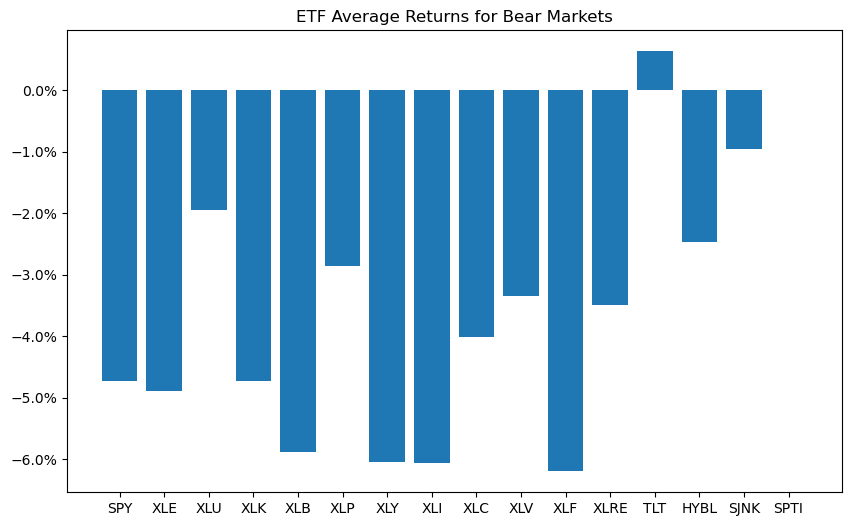

In [57]:
bear_plot = bull_bear_sector.iloc[0,:]

plt.figure(figsize=(10,6))
ticker_test = ['SPY','XLE','XLU','XLK','XLB','XLP','XLY','XLI','XLC','XLV','XLF','XLRE','TLT','HYBL','SJNK','SPTI']
plt.bar(ticker_test,bear_plot*100)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())
plt.title('ETF Average Returns for Bear Markets')

Text(0.5, 1.0, 'ETF Average Returns for Bull Markets')

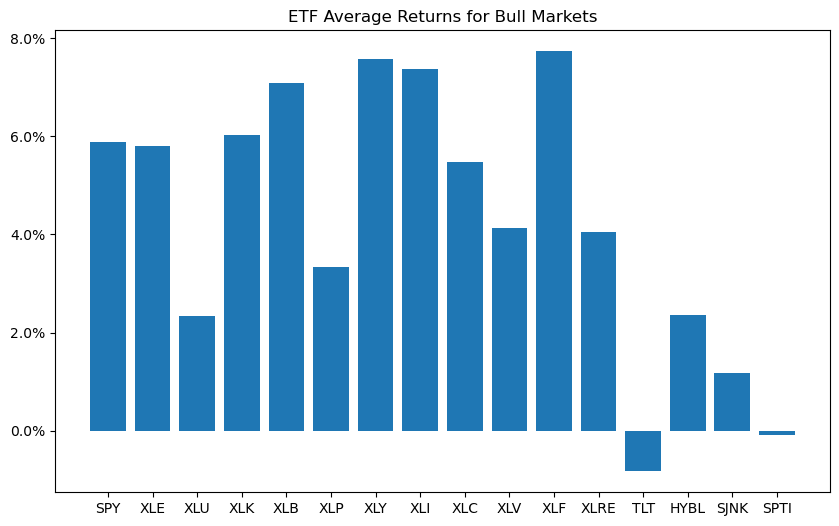

In [36]:
bear_plot = bull_bear_sector.iloc[1,:]

plt.figure(figsize=(10,6))
ticker_test = ['SPY','XLE','XLU','XLK','XLB','XLP','XLY','XLI','XLC','XLV','XLF','XLRE','TLT','HYBL','SJNK','SPTI']
plt.bar(ticker_test,bear_plot*100)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())
plt.title('ETF Average Returns for Bull Markets')